In [1]:
################################################################################
#                                                                              #
#                         Author: Bc. Petr Pouč                                #
#                         Date: April 4, 2024                                  #
#                         School: Brno University of Technology (BUT)          #
#                                                                              #
#         Master's Thesis: Optimization of Classification Models               #
#                         for Malicious Domain Detection                       #
#                                                                              #
################################################################################

import sys
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


# Add the 'FETA_code' directory to the sys.path list
# Adjust the path as necessary. If 'FETA_code' is one directory up, use '../FETA_code'
sys.path.append('..')  # Simplify the addition of the path to sys.path
from FETA_code.transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
from FETA_code.transformers.cast_timestamp import cast_timestamp

from utils.preprocess import NDF

need_to_gather_data = False # set to True to rebuild the data parquet files
use_fresh_data = False # set to True to use the latest data from DB
if need_to_gather_data:
    mode = 'force-refresh' if use_fresh_data else 'auto'
    run(cache_mode=mode)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")
warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated", category=FutureWarning)


2024-05-10 10:39:57.408281: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 10:39:57.759973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 10:39:58.959705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
feature_to_drop = "DEFAULT"

# Step 2: Training
(You can run only the next two cells and skip to the next step if you already have the model pickled)

Once the loader has loaded the data and applied the transformations, we can load the resulting parquets and prepare for model training. We then split the data into training and test sets and train a model.

In [3]:
#phishing = pq.read_table('floor/phishing_2307.parquet')
#benign = pq.read_table('floor/cesnet_2307.parquet')
#benign = pq.read_table('floor/benign_2307.parquet')

#benign = pq.read_table('floor/cesnet2.parquet')
#benign = pq.read_table('floor/benign_2307.parquet')
# benign = pq.read_table('floor/cesnet2.parquet')

#----------This was old way of doing it----------------
benign_old = pq.read_table('../floor/benign_2312.parquet')
phishing_old = pq.read_table('../floor/phishing_2311.parquet')

phishing_domain_names = phishing_old['domain_name']
benign_domain_names = benign_old['domain_name']

benign_old = benign_old.cast(phishing_old.schema)

# concatentate tables
data = pa.concat_tables([phishing_old, benign_old])
df = data.to_pandas()
df = df.drop(columns=['domain_name'])
df = cast_timestamp(df)

phishing_len = len(phishing_domain_names)
benign_len = len(benign_domain_names)


#----------This is the new way of doing it----------------
#We can use the NDF class to preprocess the data
#Missing values set to -1
#Outliers are removed
#Encoding of categorical variables - Decision tree creates new feature
#Min-Max scaling, sigmoid transformation (only if cnn is used)
#Imbalance handling

malign = "../floor/benign_2312.parquet"
benign = "../floor/phishing_2311.parquet"

#The whole preprocessing step happens here
dataset = NDF("xgboost", True, benign=benign, malign=malign)
class_map = dataset['class_map']

print(dataset['feature_names'])

X_train, X_test, y_train, y_test = train_test_split(torch.Tensor(dataset['features']), torch.Tensor(dataset['labels']), test_size=0.2, random_state=42)

print(X_train.shape)

#print labels of z?train, values distribution
print(y_train)
print(y_train.unique(return_counts=True))

2024-05-10 10:40:40,464 - utils.preprocess - INFO - Benign dataset path: ../floor/phishing_2311.parquet
2024-05-10 10:40:40,473 - utils.preprocess - INFO - Malign dataset path: ../floor/benign_2312.parquet


Malign dataset path: ../floor/benign_2312.parquet
Benign dataset path: ../floor/phishing_2311.parquet


/home/survivecz/.local/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/survivecz/.local/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/survivecz/.local/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .


Dataset Subset:
Name: dataset_../floor/phishing2311_../floor/benign2312_2024-05-10.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0        0.0   0.000000        0.0   0.000000   0.000000   0.000000   
1        0.0   0.285714        0.0   0.181818   0.307692   0.583333   
2        0.0   0.000000        0.0   0.000000   0.000000   0.000000   
3        0.0   0.071429        0.0   0.000000   0.000000   0.000000   
4        0.0   0.071429        0.0   0.000000   0.000000   0.000000   
5        0.0   0.000000        0.0   0.000000   0.000000   0.000000   
6        0.0   0.071429        0.0   0.272727   0.307692   0.041667   
7        0.0   0.000000        0.0   0.000000   0.000000   0.000000   
8        0.0   0.000000        0.0   0.000000   0.000000   0.000000   
9        0.0   0.071429        0.0   0.000000   0.000000   0.000000   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_178  Feature_179  \
0        0.0        0.0       0.00  

In [ ]:
# !pip install imblearn
# from imblearn import under_sampling, over_sampling
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train.numpy(), y_train.numpy())

# print("After balancing:")
# unique_res, counts_res = np.unique(y_train_res, return_counts=True)
# print(dict(zip(unique_res, counts_res)))

### Histogram of TLS and RDAP features for Benign and Phishing (RELATIVE)

float64 float64 timedelta64[ms]
Feature: tls_leaf_cert_validity_len, Data Type: float64
Feature: tls_root_cert_validity_len, Data Type: float64
Feature: tls_leaf_cert_lifetime, Data Type: float64
Feature: tls_root_cert_lifetime, Data Type: float64
Feature: ip_mean_average_rtt, Data Type: float64
Feature: tls_percentage_crt_with_policies, Data Type: float64


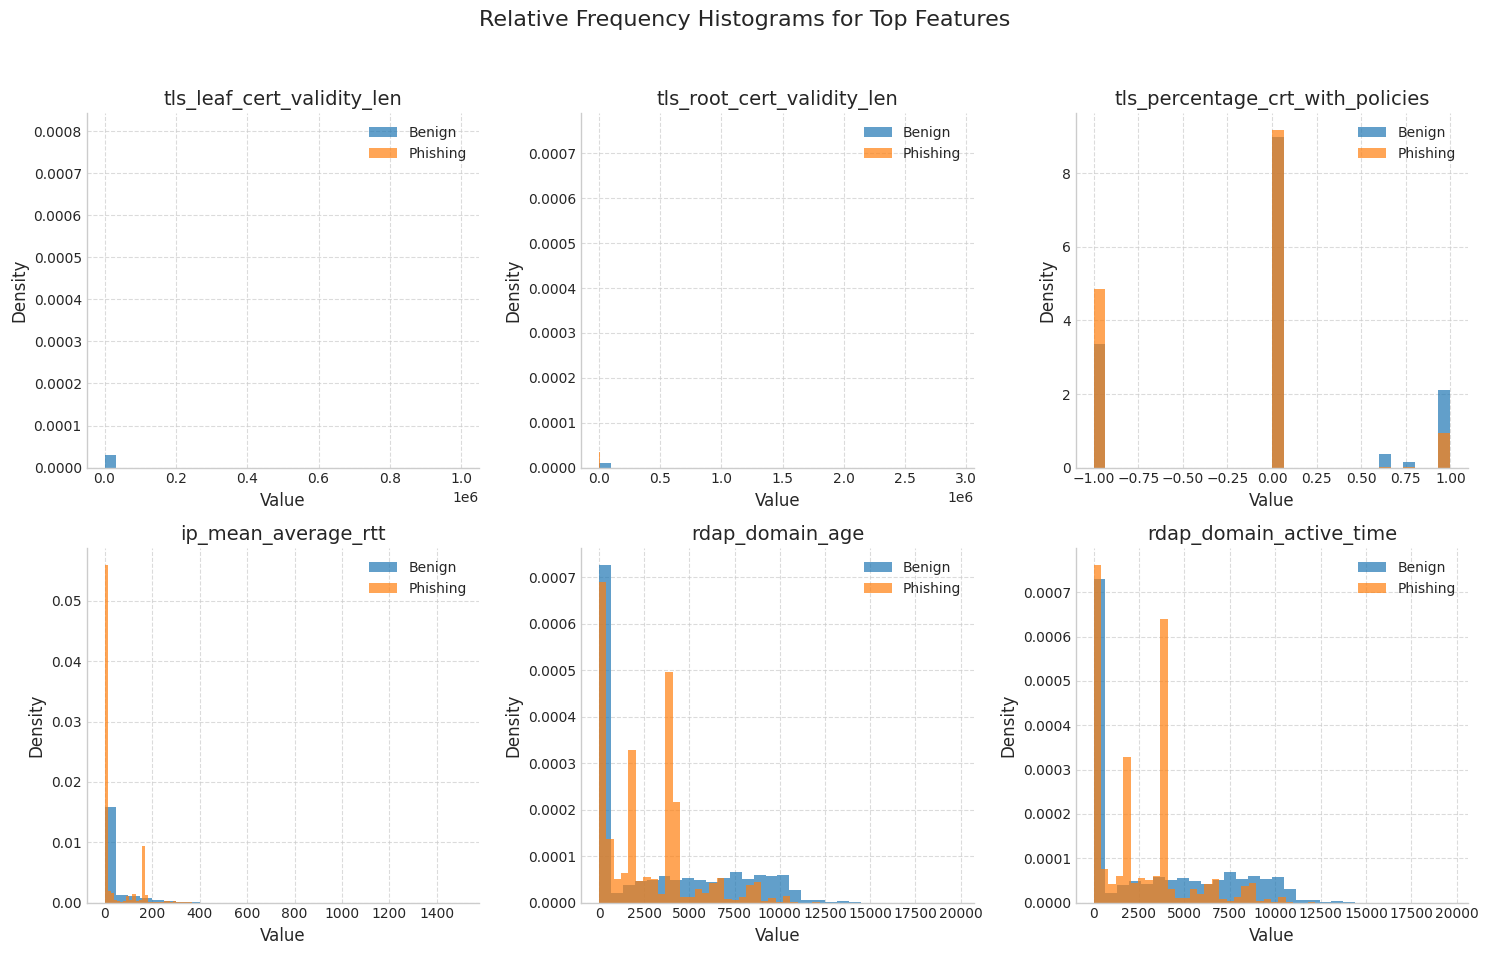

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading final dataset with domains and feature vectors
data = pq.read_table('../floor/benign_2307.parquet')
data2 = pq.read_table('../floor/phishing_2307.parquet')

# Drop nontraining columns
from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
data = drop_nontrain(data)
data2 = drop_nontrain(data2)

# Convert to pandas DataFrame
df1 = data.to_pandas()
df2 = data2.to_pandas()

print(df1['rdap_domain_age'].dtype, df1['rdap_domain_active_time'].dtype, df1['rdap_registration_period'].dtype)


# Calculate ratio of benign to phishing for features containing 'tls'
features_with_validity_len = [col for col in df1.columns if 'validity' in col]
features_with_lifetime = [col for col in df1.columns if 'lifetime' in col]
features_with_count = [col for col in df1.columns if 'count' in col]
features_with_age = [col for col in df1.columns if 'age' in col]
features_with_active_time = [col for col in df1.columns if 'active_time' in col]
features_with_period = [col for col in df1.columns if 'period' in col]

selected_features = features_with_validity_len + features_with_lifetime + features_with_age + features_with_active_time + features_with_period 
selected_features_without_age = [
    col for col in selected_features if col not in ['rdap_domain_age', 'rdap_domain_active_time', 'rdap_registration_period']
]

ratios = {}
for feature in selected_features_without_age:
    print(f"Feature: {feature}, Data Type: {df1[feature].dtype}")

    benign_count = df1[feature].count()
    phishing_count = df2[feature].count()
    
    if phishing_count != 0:
        ratio = benign_count / phishing_count
        ratios[feature] = ratio

# Convert timedelta columns to numeric representation (days) without changing names
for col in ['rdap_domain_age', 'rdap_domain_active_time', 'rdap_registration_period']:
    if pd.api.types.is_timedelta64_dtype(df1[col]):
        df1[col] = df1[col].dt.days
        df2[col] = df2[col].dt.days

# Calculate counts after converting timedelta columns to days
for col in ['rdap_domain_age', 'rdap_domain_active_time', 'rdap_registration_period']:
    benign_count = df1[col].count()
    phishing_count = df2[col].count()
    
    if phishing_count != 0:
        ratio = benign_count / phishing_count
        ratios[col] = ratio

# Sort features by ratio in descending order (including the timedelta columns)
sorted_features = sorted(ratios, key=ratios.get, reverse=True)[:9]  # Select top 9 features
custom_colors = ['#1f77b4', '#ff7f0e']  # Blue for Benign, Orange for Phishing

# Plot histograms for the top 9 features in a 3x3 subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, feature in enumerate(sorted_features[:6]):  # Limit to the first 6 features
    ax = axes[i // 3, i % 3] # Calculate subplot index
    
    lts_benign = df1[feature].fillna(-1.0)
    lts_phishing = df2[feature].fillna(-1.0)
    
    # Plot histograms using the custom color palette
    ax.hist(lts_benign, bins=30, alpha=0.7, label='Benign', density=True, color=custom_colors[0])
    ax.hist(lts_phishing, bins=30, alpha=0.7, label='Phishing', density=True, color=custom_colors[1])
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'{feature}', fontsize=14)
    ax.legend(prop={'size': 10})

    # Customize tick labels and font sizes
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Adding gridlines and removing spines
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set overall figure title
fig.suptitle('Relative Frequency Histograms for Top Features', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplot layout and spacing
plt.show()


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, average_precision_score

# Optimal parameters selected based on hyperparameter tuning
class_counts = y_train.unique(return_counts=True)[1]
weight_for_0 = class_counts[1].item() / class_counts[0].item()  # Number of majority class / number of minority class

params = {
    "max_depth": 9,
    "eta": 0.2,
    "objective": "binary:logistic",
    "min_child_weight": 2.0,
    "subsample": 0.8,
    "alpha": 0.1,
    "gamma": 0.5,
    "lambda": 1.5,
    "max_delta_step": 1,
    "grow_policy": "lossguide",
    "max_bin": 256,
    "colsample_bytree": 0.8,
    "scale_pos_weight": weight_for_0  # Adjusting scale_pos_weight for class imbalance
}
trees = 300

model = XGBClassifier(
    **params,
    n_estimators=trees,
    eval_metric="logloss"  # Using logloss for training metric, as AUPRC cannot be directly used here
)

# Set to True to cross validate
do_cross_val = True
if do_cross_val:
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score

    # Define a custom scorer for AUPRC
    auprc_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    results = cross_val_score(model, X_train.numpy(), y_train.numpy(), cv=kfold, scoring=auprc_scorer)
    print("AUPRC: %.2f%% (%.2f%%)" % (results.mean() * 100, results.std() * 100))

# Train the model
eval_set = [(X_train.numpy(), y_train.numpy()), (X_test.numpy(), y_test.numpy())]
_ = model.fit(X_train.numpy(), y_train.numpy(), eval_set=eval_set, verbose=True)  # Verbose=True to see progress


/home/survivecz/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


AUPRC: 99.46% (0.07%)
[0]	validation_0-logloss:0.33202	validation_1-logloss:0.33038
[1]	validation_0-logloss:0.30119	validation_1-logloss:0.29940
[2]	validation_0-logloss:0.27369	validation_1-logloss:0.27174
[3]	validation_0-logloss:0.24842	validation_1-logloss:0.24636
[4]	validation_0-logloss:0.22563	validation_1-logloss:0.22346
[5]	validation_0-logloss:0.20557	validation_1-logloss:0.20340
[6]	validation_0-logloss:0.18753	validation_1-logloss:0.18524
[7]	validation_0-logloss:0.17329	validation_1-logloss:0.17105
[8]	validation_0-logloss:0.15962	validation_1-logloss:0.15722
[9]	validation_0-logloss:0.14586	validation_1-logloss:0.14360
[10]	validation_0-logloss:0.13349	validation_1-logloss:0.13141
[11]	validation_0-logloss:0.12342	validation_1-logloss:0.12134
[12]	validation_0-logloss:0.11357	validation_1-logloss:0.11172
[13]	validation_0-logloss:0.10485	validation_1-logloss:0.10311
[14]	validation_0-logloss:0.09716	validation_1-logloss:0.09569
[15]	validation_0-logloss:0.09092	validatio

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


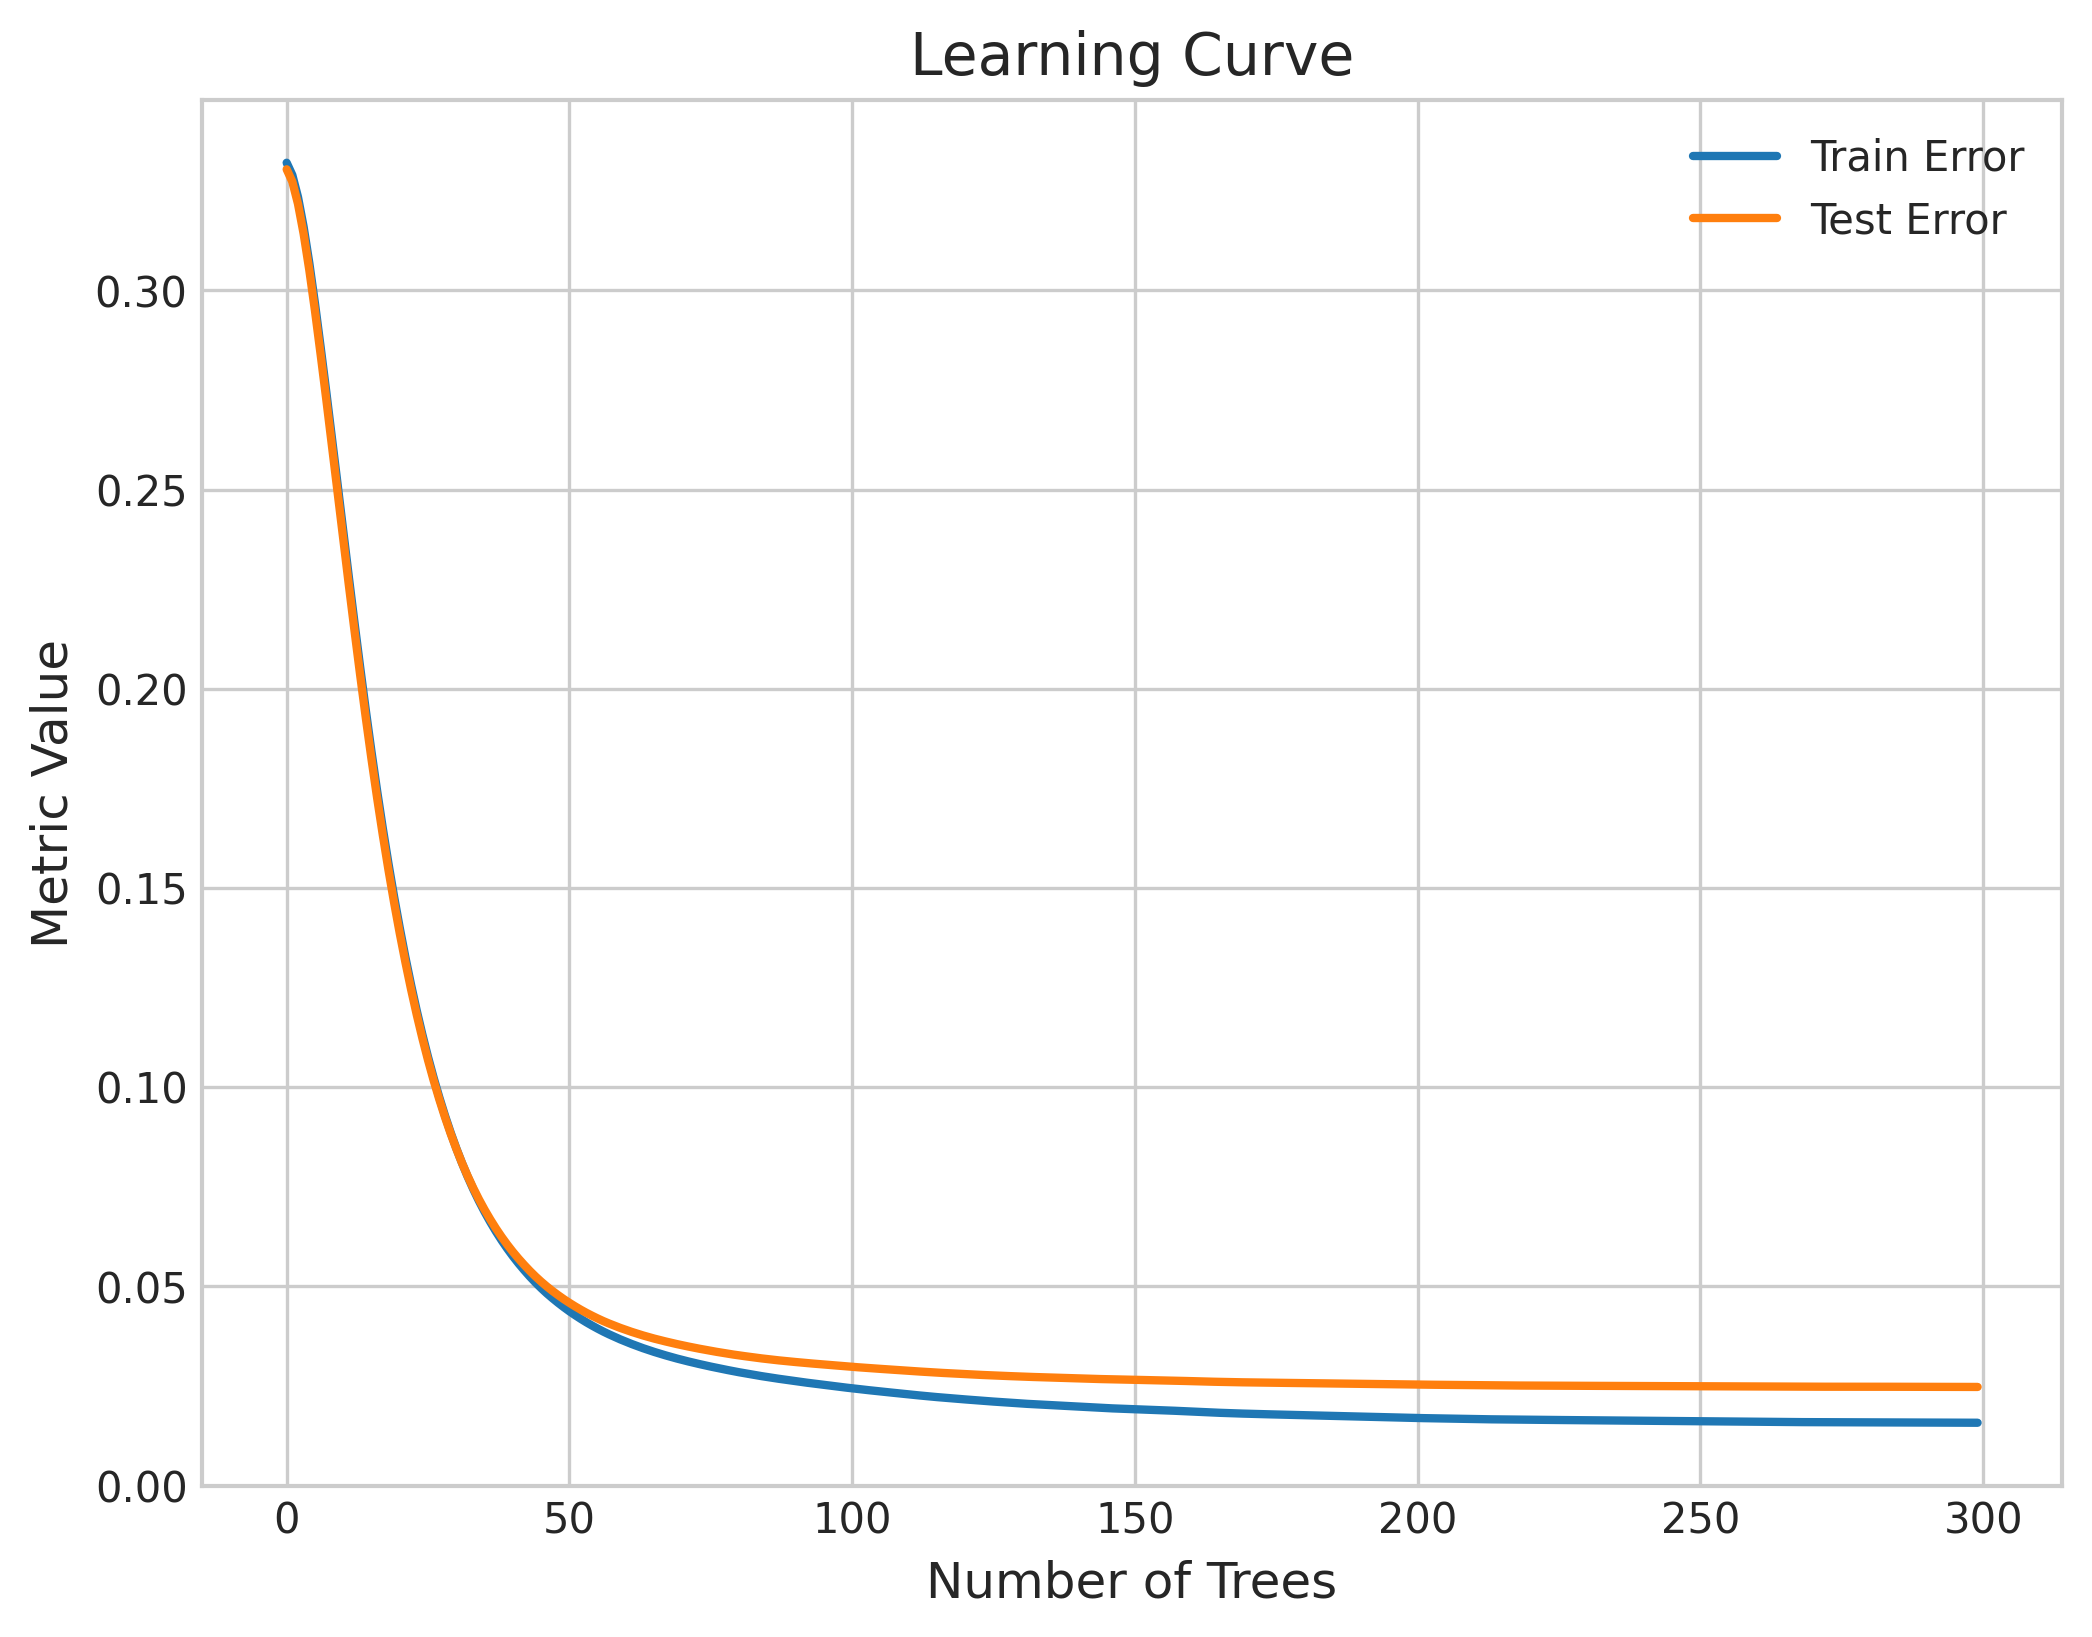

In [ ]:
# plot evaluation
results = model.evals_result()
trees = len(results['validation_0']['logloss'])
x_axis = range(0, trees)

from matplotlib import style

print(plt.style.available)


# Smoothing function to reduce noise in the learning curve
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Updated function to plot the learning curve with smoothed lines
def plot_learning_curve(metric):
    # Apply modern look
    # plt.style.use('seaborn-v0_8-whitegrid')
    
    # Retrieve metric data
    train_metric = results['validation_0'][metric]
    test_metric = results['validation_1'][metric]
    
    # Apply smoothing to the metric data
    train_metric_smoothed = smooth_curve(train_metric)
    test_metric_smoothed = smooth_curve(test_metric)
    
    # Generate the plot with improved aesthetics
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax.plot(x_axis, train_metric_smoothed, label='Train Error', linewidth=2, color='tab:blue')
    ax.plot(x_axis, test_metric_smoothed, label='Test Error', linewidth=2, color='tab:orange')
    ax.legend()
    ax.set_xlabel('Number of Trees', fontsize=12)
    ax.set_ylabel('Error' if metric == 'error' else 'Metric Value', fontsize=12)
    ax.set_title('Learning Curve', fontsize=14)
    plt.show()

# Plotting the smoothed learning curve for 'error'
plot_learning_curve('logloss')

In [ ]:
# import pickle
# pickle.dump(model, open("xgboost_model.pickle.dat", "wb"))

# # Save X_train to a pickle file
# with open('X_train.pickle.dat', 'wb') as file:
#   pickle.dump(X_train, file)

# # Save Y_train to a pickle file
# with open('y_train.pickle.dat', 'wb') as file:
#   pickle.dump(y_train, file)

# Step 3: Evaluating the model's performance
(You can run the next cell only and then skip to the next step if you just want to play with SHAP)

We can now load the model at any time and use it to make predictions. We can also evaluate its performance on the test set. The following cell will load the model and evaluate it on the test set. It will also print the confusion matrix and classification report.

In [ ]:
# import pickle
# model = pickle.load(open("xgboost_model.pickle.dat", "rb"))

0.9686907020872866
              precision    recall  f1-score   support

         0.0     0.9924    0.9994    0.9959     80202
         1.0     0.9951    0.9436    0.9687     10820

    accuracy                         0.9927     91022
   macro avg     0.9938    0.9715    0.9823     91022
weighted avg     0.9928    0.9927    0.9927     91022



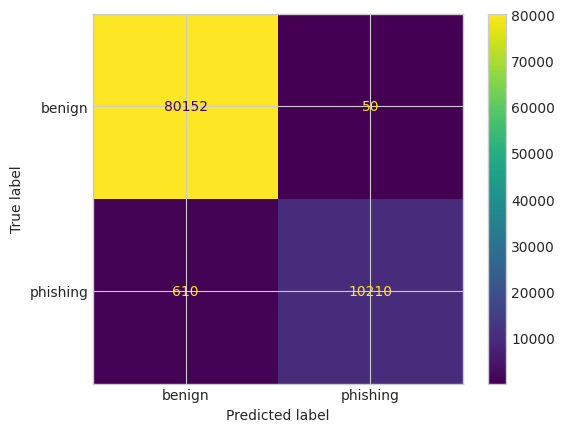

In [ ]:
predicted = model.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, predicted, digits=4))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['benign', 'phishing'], values_format='d')

In [ ]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# import pandas as pd

# # Assuming y_test and predicted_np are properly formatted for confusion_matrix
# confusion_matrix_result = confusion_matrix(y_test.numpy(), predicted_np)
# TN, FP, FN, TP = confusion_matrix_result.ravel()

# # Get the indices of false positive instances directly
# # Convert false_positive_indices to a PyTorch tensor if it's not already
# false_positive_indices_tensor = torch.tensor(false_positive_indices, dtype=torch.long)

# # Use PyTorch indexing to select the false positive domains
# false_positive_domains = X_test[false_positive_indices_tensor]


# #convert false_positive_domains_list back to ints
# false_positive_domains_list = [int(i) for i in false_positive_domains_list]


# #from each number in false_positive_domains_list substract len of phishing domains, because false positives are only in benign for now
# false_positive_domains_list = [i - phishing_len for i in false_positive_domains_list]
# domain_names = benign_domain_names.to_pandas().iloc[false_positive_domains_list]


# #create dictionary from domain_names with format index as key and domain as value
# domain_names_dict = domain_names.to_dict()
# #to each index of this dict add len of phishing domains, because false positives are only in benign for now
# domain_names_dict = {int(k): v for k, v in domain_names_dict.items()}
# domain_names_dict = {v: k + phishing_len for k, v in domain_names_dict.items()}
# print(domain_names_dict)

# #read df_false_positives csv file and add column domain_name to each row with value based on index from domain_names_dict
# df_false_positives = pd.read_csv('false_positives/false_positive_df.csv', sep='\t')
# os.remove('false_positives/false_positive_df.csv')

# #print key for each row in df_false_positives
# for index, row in df_false_positives.iterrows():
#     index_value = row['Unnamed: 0']
#     key = list(domain_names_dict.keys())[list(domain_names_dict.values()).index(index_value)]
#     df_false_positives.at[index, 'domain_name'] = key

# #move column domain_name to the first position
# df_false_positives = df_false_positives[['domain_name'] + [col for col in df_false_positives.columns if col != 'domain_name']]

# df_false_positives.to_excel('false_positives/FP.xlsx', index=False)
# print(df_false_positives.head(1))


# Step 4: Explaining the model's predictions
(You can start from the cell where the pickled shap values are loaded if you already have them)

We can now use SHAP to gain insight into the model's predictions. First, shap values need to be computed for the test set. This is a computationally expensive process, but in practice, you can significantly reduce the time needed by using a narrower sample of the data, without affecting the results much. The following cell will compute shap values for the test set. It will also save the shap values to a file, so you can load them later without having to recompute them.

In [ ]:
# initialize shap
import shap
# get shap values (use a smaller sample of the test set if you want to save coffee)
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
# save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))

The shap values are now stored. You can later start all the way here (after running the mandatory cells in previous steps) to only play with SHAP.

In [ ]:
# load the values to start from here
import pickle
shap_values = pickle.load(open("shap_values.pickle.dat", "rb"))

In [ ]:
import shap
shap.initjs()
reverse_class_map = {v: k for k, v in class_map.items()}

## Force plot
The force plot shows the shap values for a single prediction. The values are sorted by their absolute value, so the most important features are the largest arrows. The color indicates the influence of the feature. The red color indicates a positive value, while the blue color indicates a negative value. The base value is the average prediction for the whole dataset. The output value is the prediction for the selected sample. The sum of the base value and the shap values is equal to the output value. You can see how each feature "forces" the shap value to its final resting position, determining the resulting prediction.

Note that the force plot is interactive, but that breaks with widgets. So instead just change the sample variable to see different samples and rerun the cell.

In [ ]:
import numpy as np

def get_feature_with_highest_shap(shap_values, feature_names, sample_index):
    # Compute the absolute SHAP values for the sample
    abs_shap_values = np.abs(shap_values[sample_index, :])
    
    # Find the index of the highest SHAP value
    highest_shap_index = np.argmax(abs_shap_values)

    # Use the index to get the feature name from the provided list
    feature_name = feature_names[highest_shap_index]
    feature_value = dataset[sample_index, highest_shap_index].item()  # .item() converts a single-element tensor to a Python scalar

    return feature_name, feature_value


## Creating force plots for each sample + getting feature with highest shap value

In [ ]:
# import matplotlib.pyplot as plt
# import os
# import numpy as np

# # Indexes of all false positives
# print(f'FP indexes: {domain_names_dict.values()}')

# # Print all possible indexes to ../false_positives/indexes.txt
# list_of_indexes = []
# with open('false_positives/indexes.txt', 'w') as f:
#     for item in X_test.index:
#         f.write("%s\n" % item)
#         list_of_indexes.append(item)

# # Index of FP in the dataframe is not the same as the index of FP in X_test, so we need to convert it
# FP_index_xtest = [i for i, x in enumerate(list_of_indexes) if x in domain_names_dict.values()]
# FP_index_xtest = [i + 1 for i in FP_index_xtest]

# FP_index = list_of_indexes.index(49178) + 1
# # The same way, create a list FP_index with all false positive indexes

# if not os.path.exists('false_positives/force_plots'):
#     os.makedirs('false_positives/force_plots')

# # Create a dictionary to store the highest SHAP values for each false positive
# highest_shap_values = {}
# feature_names = []
# plt.figure(figsize=(8, 6))
# # SHAP force plot for all FP in FP_index_xtest and save them to ../false_positives/FP_force_plots as pdf

# for i in FP_index_xtest:
#     #print len of FP_index_xtest
#     feature_name, adjusted_feature_value = get_feature_with_highest_shap(shap_values, X_test, i)
#     # Get domain name from list_of_indexes
#     domain_name_index = list_of_indexes[i - 1]
#     domain_name = list(domain_names_dict.keys())[list(domain_names_dict.values()).index(domain_name_index)]
#     #print("Feature with Highest SHAP Value for %s: %s (%.2f)" % (domain_name, feature_name, adjusted_feature_value))
    
#     # Save the highest SHAP values to the dictionary
#     highest_shap_values[domain_name] = (feature_name, adjusted_feature_value)
#     feature_names.append(feature_name)
    
#     shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], show=False, matplotlib=True)
#     plt.savefig('false_positives/force_plots/FP_force_plot_' + str(i) + '.pdf', bbox_inches='tight')
#     plt.close()

#     # Create an Explanation object
#     expl = shap.Explanation(values=shap_values[i, :],
#                            base_values=explainer.expected_value,
#                            data=X_test.iloc[i, :],
#                            feature_names=X_test.columns)

#     # Check if the directory to save the waterfall plots exists, if not create it
#     if not os.path.exists('false_positives/waterfall_plots'):
#         os.makedirs('false_positives/waterfall_plots')
    
#     # Save the SHAP waterfall plot to ../false_positives/waterfall_plots as pdf
#     plt.figure()
#     shap.waterfall_plot(expl, show=False)
#     plt.savefig(f'false_positives/waterfall_plots/FP_waterfall_plot_{i}.pdf', bbox_inches='tight')
#     plt.close()

# # Sort the dictionary by adjusted_feature_value in descending order
# sorted_highest_shap_values = dict(sorted(highest_shap_values.items(), key=lambda x: x[1][1], reverse=True))

# # Save the sorted highest SHAP values to /false_positives/highest_shap.txt
# with open('false_positives/highest_shap.txt', 'w') as f:
#     for domain_name, (feature_name, adjusted_feature_value) in sorted_highest_shap_values.items():
#         f.write("Domain: %s, Feature: %s, SHAP Value: %.2f\n" % (domain_name, feature_name, adjusted_feature_value))

# #print feature_names
# print(feature_names)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from collections import Counter

# def read_shap_data(filepath):
#     feature_shap_values = {}
#     feature_shap_count = {}  # Initializing a dictionary to hold feature counts
#     domain_names = {}

#     with open(filepath, 'r') as f:
#         for line in f:
#             parts = line.strip().split(', ')
#             domain_name = parts[0].split(': ')[1]
#             feature_name = parts[1].split(': ')[1]
#             shap_value = float(parts[2].split(': ')[1])

#             feature_shap_values.setdefault(feature_name, []).append(shap_value)
#             feature_shap_count[feature_name] = feature_shap_count.get(feature_name, 0) + 1  # Incrementing the feature count
#             domain_names.setdefault(feature_name, []).append(domain_name)  # Changed key to feature_name only

#     return feature_shap_values, feature_shap_count, domain_names

# def summarize_shap_values(feature_shap_values, feature_shap_count, domain_names):
#     feature_summary = {
#         'Feature': [],
#         'Most Common SHAP Value': [],
#         'Count': [],
#         'Domains': []
#     }

#     for feature_name, shap_values in feature_shap_values.items():
#         most_common_value, most_common_count = Counter(shap_values).most_common(1)[0]
#         domains = domain_names.get(feature_name, [])  # Updated to use feature_name as key
#         feature_summary['Feature'].append(feature_name)
#         feature_summary['Most Common SHAP Value'].append(most_common_value)
#         feature_summary['Count'].append(feature_shap_count[feature_name])  # Adding the feature count here
#         feature_summary['Domains'].append(", ".join(domains))  # Join domain names into a string

#     return pd.DataFrame(feature_summary)

# def visualize_summary(summary_df):
#     sns.set(style="whitegrid", font_scale=1.2)  # Set the style to whitegrid and increase font scale
    
#     plt.figure(figsize=(20, 12))
#     vibrant_palette = sns.color_palette("bright", n_colors=len(summary_df))
    
#     sns.barplot(data=summary_df, x='Feature', y='Most Common SHAP Value', palette=vibrant_palette)
    
#     plt.yscale('log')
#     plt.title('Most Common SHAP Values by Feature (Log Scale)', fontsize=24)
#     plt.xticks(rotation=45, ha="right", fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.tight_layout()
#     plt.xlabel('Feature', fontsize=20)
#     plt.ylabel('Most Common SHAP Value (log scale)', fontsize=20)
    
#     plt.savefig('false_positives/images/most_common_shap_values.pdf', bbox_inches='tight')
#     plt.show()


# # Main execution
# filepath = 'false_positives/highest_shap.txt'
# feature_shap_values, feature_shap_count, domain_names = read_shap_data(filepath)
# summary_df = summarize_shap_values(feature_shap_values, feature_shap_count, domain_names)
# summary_df = summary_df.sort_values(by='Most Common SHAP Value', ascending=False)


# summary_df['Domains'] = summary_df['Domains'].str.split(', ')
# summary_df = summary_df.explode('Domains')
    
# summary_df.to_excel('false_positives/summary_df.xlsx', index=False)  # Saving summary_df to excel
# print(summary_df)
# visualize_summary(summary_df)

    
    

### Feature Importance (directly extracted from the model)

XGBoost has a built-in function to plot feature importance directly. The variable `feature_importances` holds the importance scores derived from the machine learning model. These scores signify the contribution of each feature to the model's predictive performance.

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


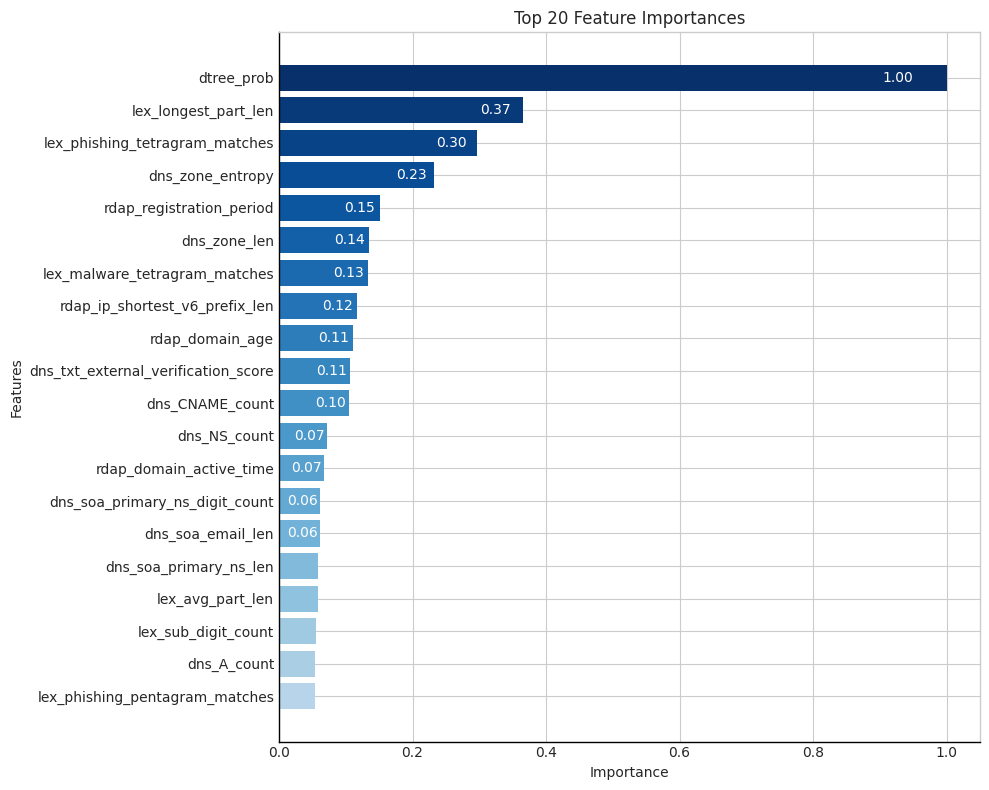

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

# Your data setup remains unchanged
feature_names = dataset['feature_names'] if 'feature_names' in dataset else [f"Feature {i}" for i in range(len(model.feature_importances_))]
feature_importances = model.feature_importances_
normalized_importances = (feature_importances - np.min(feature_importances)) / (np.max(feature_importances) - np.min(feature_importances))
sorted_indices = np.argsort(feature_importances)[::-1]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_names[i] for i in top_20_indices]
top_20_normalized_importances = normalized_importances[top_20_indices]

# Modified plotting to include gradient colors and value labels
plt.figure(figsize=(10, 8))
colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_20_normalized_importances)))
bars = plt.barh(top_20_feature_names, top_20_normalized_importances, color=colors)

# Adjusted value labels placement to be inside or outside based on the bar width
for bar, value in zip(bars, top_20_normalized_importances):
    bar_width = bar.get_width()
    threshold = 0.06  # Adjust this threshold based on your data
    if bar_width > threshold:  # Enough room to place the text inside
        text_position = bar_width - 0.05 * bar_width  # Adjust this to make sure text fits well inside the bar
        plt.text(text_position, bar.get_y() + bar.get_height() / 2, f"{value:.2f}", va='center', ha='right', color='white')
    else:  # Not enough room, place the text outside
        pass

plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1)

plt.tight_layout()
plt.show()


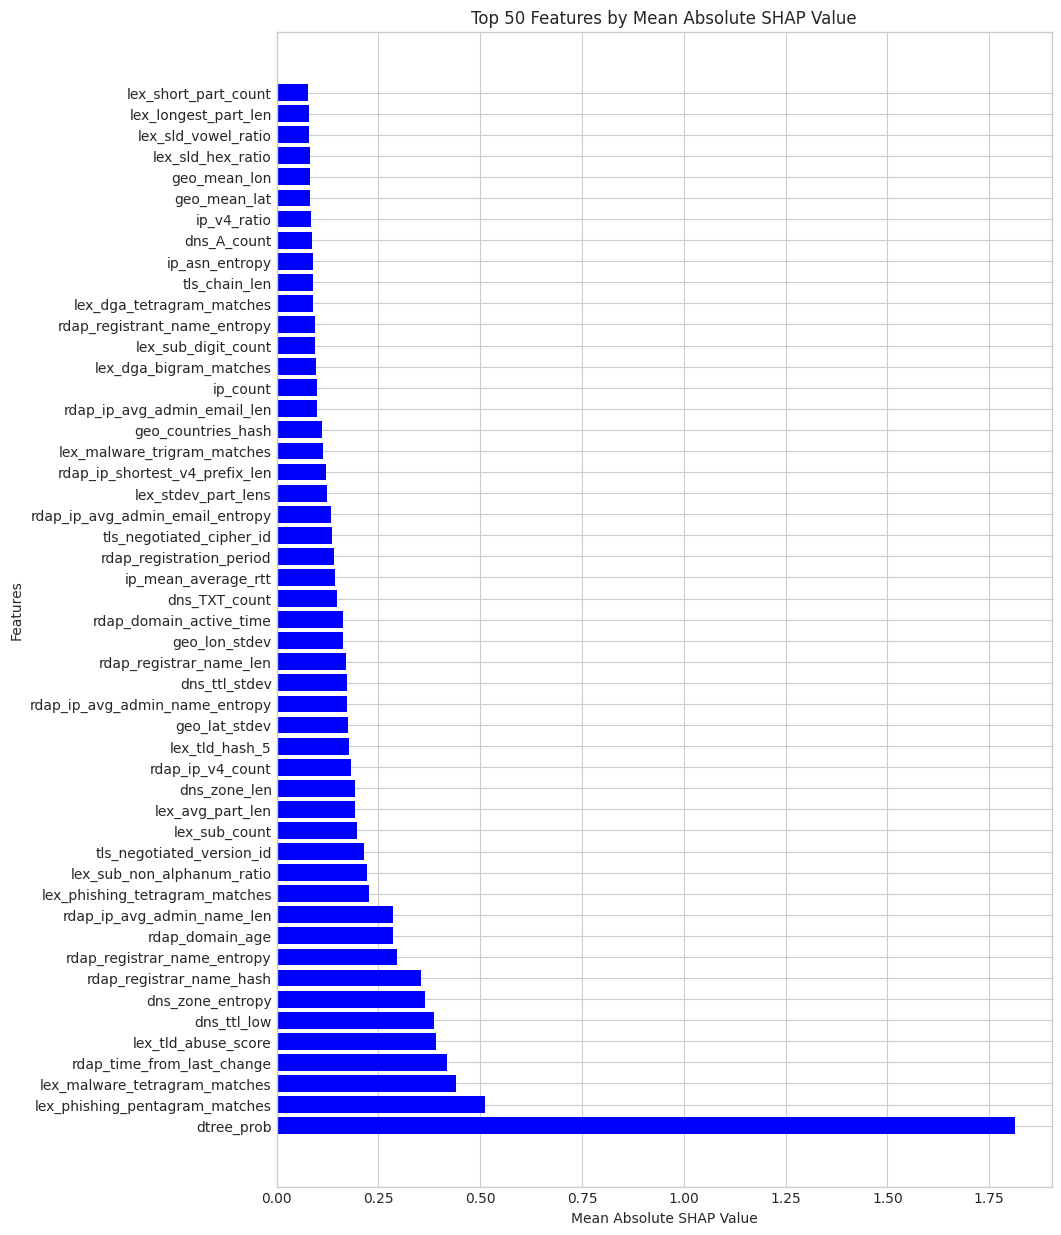

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(model)
X_test_numpy = X_test.numpy()
shap_values = explainer.shap_values(X_test_numpy)


shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_numpy[0])

# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Sort features by their mean absolute SHAP value in descending order
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Slice to get the top 50 features
top_50_indices = sorted_indices[:50]
feature_names = dataset['feature_names']


top_50_feature_names = np.array(feature_names)[top_50_indices]
top_50_shap_values = mean_abs_shap_values[top_50_indices]

# Plotting the top 50 features
plt.figure(figsize=(10, 15))
plt.title("Top 50 Features by Mean Absolute SHAP Value")
plt.barh(range(50), top_50_shap_values[::-1], color='blue')
plt.yticks(range(50), top_50_feature_names[::-1])
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.show()


# Summary plot
The summary plot shows (in dot or violin mode) how individual feature values are distributed for each feature. The x-axis shows the shap value, while the color shows the feature value. The features are sorted by their importance, so the most important features are at the top. The color indicates the value of the feature. The red color indicates a high value, while the blue color indicates a low value. The zero line is the split point between outputs, just like the base value in the force plot. For some features, you might see that low values usually result in negative classification, while high values usually result in positive classification.

Another mode, bar, shows a mean shap value across all data points, which is effectively a plot of feature importance. Use the widgets to switch between modes and feature count. Also note that the violin and dot plots take a while to calculate, so you might want to start with a low feature count.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import shap

explainer = shap.TreeExplainer(model)

# Convert X_test from PyTorch tensor to numpy array for SHAP compatibility
X_sample = X_test.numpy()
shap_values = explainer.shap_values(X_sample)

# Save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))

plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)

max_display = widgets.IntSlider(
    value=10,
    description='Max Display:',
    disabled=False,
    min=1,
    max=len(feature_names)-1  
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type=plot_type, class_names=class_map.values(), max_display=max_display, plot_size=[10, max_display])


interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…

In [ ]:
feature_names = dataset['feature_names']  
all_features_gain = {f'f{i}': 0 for i in range(len(feature_names))}
gain_scores = model.get_booster().get_score(importance_type='gain')
all_features_gain.update(gain_scores)

sorted_score = sorted(all_features_gain.items(), key=lambda x: x[1], reverse=True)

sorted_score_with_names = [(feature_names[int(k[1:])], v) if k.startswith('f') else (k, v) for k, v in sorted_score]

# Display the sorted scores with feature names
sorted_score_with_names


[('dtree_prob', 207.9984893798828),
 ('lex_longest_part_len', 76.06309509277344),
 ('lex_phishing_tetragram_matches', 61.534332275390625),
 ('dns_zone_entropy', 48.406150817871094),
 ('rdap_registration_period', 31.44234275817871),
 ('dns_zone_len', 28.171628952026367),
 ('lex_malware_tetragram_matches', 27.7913761138916),
 ('rdap_ip_shortest_v6_prefix_len', 24.210025787353516),
 ('rdap_domain_age', 22.967021942138672),
 ('dns_txt_external_verification_score', 22.2557373046875),
 ('dns_CNAME_count', 21.827964782714844),
 ('dns_NS_count', 15.003496170043945),
 ('rdap_domain_active_time', 14.146045684814453),
 ('dns_soa_primary_ns_digit_count', 12.886916160583496),
 ('dns_soa_email_len', 12.764113426208496),
 ('dns_soa_primary_ns_len', 12.130722999572754),
 ('lex_avg_part_len', 12.044099807739258),
 ('lex_sub_digit_count', 11.4078369140625),
 ('dns_A_count', 11.15341854095459),
 ('lex_phishing_pentagram_matches', 11.142642974853516),
 ('geo_lon_stdev', 10.71336841583252),
 ('lex_tld_hash